# Example with tidal flume

In this simulation that seems to mimic a lab experiment, there is a long channel with one tidally forced boundary
on the left. At inflow on the left boundary salt sea-water will intrude into the channel. The channel is 130m
long, 1m wide and 20 cm deep. The "tide" on the left bounday has a period of 10 minutes and an amplitude of 0.75 cm. The inflowing water has a salinity of 12.5 psu. The net inflow on the right boundary is 0.005 m^3/s.
The simulation starts at rest with fresh water in the entire basin and finishes after 100 minutes, equaling 10 cycles.


In [1]:
# Load required libraries
using Pkg
Pkg.precompile() # command needed after modifying the src code
Pkg.activate("..")
using Particles
using Plots
using Random
using ZipFile

randpool = MersenneTwister(0) #Generate same random numbers every time

nothing

Precompiling project...


  ✓ Particles


  1 dependency successfully precompiled in 21 seconds. 249 already precompiled.
  Activating project at `j:\Master_Thesis\particles.jl`


In [2]:
# unzip the flow data (if not already done)

# function unzip(file,exdir="")
# extract all files from zip file to exdir
function unzip(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) ? "" : mkdir(outPath)
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end

if !isdir("./data/tidal_flume_map.zarr") 
    unzip("./data/tidal_flume_map.zip","./data")
end


In [17]:
# Load default settings and adjust

# collected configuration is in Dict d
d = default_userdata() # start with some defaults

# settings for this experiment
n = 100 # number of particles
d["nparticles"] = n
# problem specific settings
x_min_release = 4.0 # release particles in this znode
d["x_min_release"] = x_min_release
x_max_release = 6.0 
d["x_max_release"] = x_max_release
z_min_release = -0.2  
d["z_min_release"] = z_min_release
z_max_release = -0.1
d["z_max_release"] = z_max_release
y_release = 1.0
d["y_release"] = y_release 

# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = x_min_release .+ (x_max_release - x_min_release) .* rand(randpool, n, 1) # x
p[2, :] .= y_release # y
p[3, :] = z_min_release .+ (z_max_release - z_min_release) .* rand(randpool, n, 1) # z
p[4, :] .= 0.0 # age
d["particles"] = p # initial values
# simulation time
d["dt"] = 30.0     #time-step
d["tstart"] = 0 #start after 2 cycles
d["tend"]   = 3600.0 #3600.0
tstart=d["tstart"] 
tend=d["tend"]
# write to netcdf
d["write_maps_times"] = collect(0.0:30.0:tend)
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_tidal_flume.nc"
# write plots to file
d["plot_maps_times"] = collect(0.0:30.0:tend)
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(900,300)
d["plot_maps_func"] = plot_maps_xz

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(tstart:30.0:tend)

d #show configuration

Dict{String, Any} with 29 entries:
  "plot_maps_prefix"     => "map"
  "write_maps"           => false
  "reftime"              => DateTime("2000-01-01T00:00:00")
  "particles"            => [5.93882 4.94615 … 4.90973 5.34309; 1.0 1.0 … 1.0 1…
  "nparticles"           => 100
  "plot_maps_times"      => [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0,…
  "dt"                   => 30.0
  "tend"                 => 3600.0
  "write_maps_dir"       => "."
  "write_maps_filename"  => "output_tidal_flume.nc"
  "z_min_release"        => -0.2
  "variables"            => ["x", "y", "z", "age"]
  "x_min_release"        => 4.0
  "keep_particle_times"  => [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0,…
  "dumval"               => 9999.0
  "write_maps_as_series" => true
  "keep_particles"       => true
  "z_max_release"        => -0.1
  "plot_maps_func"       => plot_maps_xz
  ⋮                      => ⋮

In [18]:
# Load flow data and create interpolators

Zarr_data = ZarrData("./data","tidal_flume_map.zarr")
t0=get_reftime(Zarr_data)
h=initialize_interpolation(Zarr_data,"waterlevel",t0)
u=initialize_interpolation(Zarr_data,"x_velocity",t0)
function v(x,y,z,t) # interpolation of v is implemented but gives no useful addition to the zeros below
    return 0.0
end
function w(x,y,z,t) #TODO make interpolation of w work
    return 0.0
end
s=initialize_interpolation(Zarr_data,"salinity",t0)

nothing

In [19]:
# the following options are to be added in the default_userdata() function
# if to apply the algorithm to prevent the algorithm from crossing the boundary or not
d["is_cross_bc"] = false # if added, the algorithm will terminate once the particle is out of the boundary
d["is_apply_cross_bc_test"] = false # if applied, only one particle is used and all virtual trajectories are also recorded
if d["is_apply_cross_bc_test"]
    d["the_virtual_trajectory"] = d["particles"]
end
# to be added according to the actual problem
d["is_particle_in_domain"] = x -> nothing
d["is_keep_these_particles"] = trues(d["nparticles"],) # check if particles move out of the is_particle_in_domain
d["recursion_depth"] = 10

#
d["nparticles_bound"] = 20

# Randompool setup and restart
randpool = MersenneTwister(123) #Generate same random numbers every time
d["rng"] = randpool


MersenneTwister(123)

┌ Info: Saved animation to j:\Master_Thesis\particles.jl\case_tidal_flume\tidal_flume.gif
└ @ Plots C:\Users\hugo1111234\.julia\packages\Plots\3BCH5\src\animation.jl:156


Plots.AnimatedGif("j:\\Master_Thesis\\particles.jl\\case_tidal_flume\\tidal_flume.gif")
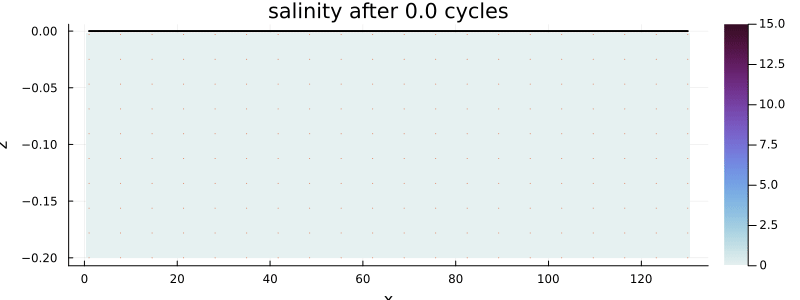

In [20]:
# create an animation of the flow field
x_left = 1.0
x_right = 130.0
y_middle = 1.0
z_surface = -0.003

z_bottom = -0.2
t_start=0.0 #Skip first 20 minutes -= 2 cycles
t_step=60.0 # 6s in file, here coarser
t_stop=3600.0 #max 100minutes=6000s with steps 6s / period is 600s

#grid for plotting arrows
xgrid=collect(range(x_left,x_right,length=20))
zgrid=collect(range(z_bottom,z_surface,length=10))
nx=length(xgrid)
nz=length(zgrid)
xs=repeat(xgrid,1,nz)
zs=repeat(zgrid,1,nx)'

anim = @animate for t in range(t_start, stop = t_stop-t_step, step = t_step)
    # grid for plotting only
    x_points = range(x_left,stop=x_right,length=130)
    z_points = range(z_bottom,stop=z_surface,length=100)
    #u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
    s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity
    h_interp = [h(x,y_middle,0.0,t) for x in x_points] # water level

    #l = @layout([a; b])
    #p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity time=$(t)",clims=(-0.5,0.5))
    p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity after $(t/600.0) cycles",clims=(0,15),color=:dense)
    quiver!(p2,vec(xs),vec(zs),quiver=(u.(vec(xs),y_middle,vec(zs),t),w.(vec(xs),y_middle,vec(zs),t)), arrowscale=0.6, headsize=0.1)
    #plot(p1,p2,layout=l,size=(800,300))
    plot!(p2,x_points,h_interp,label=false,linewidth=2,color=:black)
    plot(p2,size=(800,300))
end

gif(anim, "./tidal_flume.gif", fps = 4)

In [21]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes as ds the function f in the equation ds=f(s,t)dt+g(s,t)dw 
for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = u(x, y, z, t)
   # dy/dt=v
    ∂s.y = v(x, y, z, t)
   # dz/dt=0
    ∂s.z = w(x, y, z, t)
   # age=(t-t0)
    ∂s.t = 1.0
end
d["f"] = f!

#
# TODO: add function g! to simulate diffusion to simulation routine
#

"""
   !g(ds,s,t,i,d)

   Dynamic model, computes as ds the function g in the equation ds=f(s,t)dt+g(s,t)dw 
   for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function g!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = 0.0
   # dy/dt=v
    ∂s.y = 0.0
   # dz/dt=0
    ∂s.z = 0.0
   # age=(t-t0)
    ∂s.t = 0.0
end
d["g"] = g!

g! (generic function with 1 method)

In [22]:
#run the actual particle model

@time run_simulation(d)

writing output to memory at t = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0  …  3330.0, 3360.0, 3390.0, 3420.0, 3450.0, 3480.0, 3510.0, 3540.0, 3570.0, 3600.0]
interrupt simulation for output at t = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0  …  3330.0, 3360.0, 3390.0, 3420.0, 3450.0, 3480.0, 3510.0, 3540.0, 3570.0, 3600.0]


Simulation from time 0s to 3600.0s since 2000-01-01T00:00:00

t=0 -> 0.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 0.0%
The number of particle is 100.
simulate! runs for once.


t=0 -> 30.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:30 : 0.8%
The number of particle is 100.


KeyError: KeyError: key "is_particles_active" not found

In [23]:
# create an animation of the flow field
x_left = 1.0
x_right = 130.0
y_middle = 1.0
z_surface = -0.003

z_bottom = -0.2
t_start=1800.0 #Skip first 30 minutes = 3 cycles
t_step=60.0 # 6s in file, here coarser
t_stop=3600.0 #max 100minutes=6000s with steps 6s / period is 600s

#grid for plotting arrows
xgrid=collect(range(x_left,x_right,length=20))
zgrid=collect(range(z_bottom,z_surface,length=10))
nx=length(xgrid)
nz=length(zgrid)
xs=repeat(xgrid,1,nz)
zs=repeat(zgrid,1,nx)'

anim = @animate for t in range(t_start, stop = t_stop-t_step, step = t_step)
    # grid for plotting only
    x_points = range(x_left,stop=x_right,length=130)
    z_points = range(z_bottom,stop=z_surface,length=100)
    #u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
    s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity
    h_interp = [h(x,y_middle,0.0,t) for x in x_points] # water level

    l = @layout([a ; b])
    p1=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity after $(t/600.0) cycles",clims=(0,15),color=:dense,legend=false)
    plot!(p1,x_points,h_interp,label=false,linewidth=2,color=:black)
    # add particles
    itime=findmin(abs.(t.-d["keep_particle_times"]))[2]
    age=d["all_particles"][itime][4,:]./600.0 # in cycles
    #println("time=$(t/600.0) cycles, age=$(sum(age)/length(age))")
    p2=scatter(d["all_particles"][itime][1,:],d["all_particles"][itime][3,:],zcolor=age,clims=(0,3.0),xlims=(x_left,x_right),ylims=(z_bottom,z_surface))
    plot(p1,p2,size=(1200,500),layout=l)
end

gif(anim, "./tidal_flume.gif", fps = 4)

BoundsError: BoundsError: attempt to access 1-element Vector{Any} at index [61]